In [1]:
#Import statements
from sqlalchemy import create_engine
import cx_Oracle
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
#Connect to oracle DB

host='localhost'
port=1521
sid='springboard'
user='springboard'
password='springboard123'
sid = cx_Oracle.makedsn(host, port, sid=sid)

cstr = 'oracle://{user}:{password}@{sid}'.format(
    user=user,
    password=password,
    sid=sid
)

engine =  create_engine(
    cstr,
    convert_unicode=False,
    pool_recycle=10,
    pool_size=50,
    echo=False
)


In [5]:
#Let's continue with our preliminary analysis of the data
#First let's find out which are the most common procedures

query2 = engine.execute('SELECT HCPCS_CODE, HCPCS_DESCRIPTION, COUNT(*) '
                        'FROM MEDICARECHARGESFINAL '
                        'WHERE HCPCS_CODE NOT LIKE {} '
                        'GROUP BY HCPCS_CODE, HCPCS_DESCRIPTION '
                        'HAVING COUNT(*) >= 10000 '
                        'ORDER BY COUNT(*) DESC '.format(("'99%'")))

df2 = pd.DataFrame(query2.fetchall())
df2.columns = query2.keys()
print(df2.head())   

  hcpcs_code                                  hcpcs_description  COUNT(*)
0      G0008          Administration of influenza virus vaccine    140912
1      36415  Insertion of needle into vein for collection o...     93570
2      G0009             Administration of pneumococcal vaccine     89307
3      90662    Vaccine for influenza for injection into muscle     85351
4      93000  Routine EKG using at least 12 leads including ...     83106


In [6]:
#cpt_list - to be used in correlation calculation
#cpt_list_str - CPT codes to be used in query
# refinedList - formats cpt_list_str to be used inside SQL query

cpt_list = df2['hcpcs_code'].tolist()

df2['hcpcs_str'] = '\'' + df2['hcpcs_code'] + '\''
df2.hcpcs_str.head()



cpt_list_str = df2['hcpcs_str'].tolist()

refinedList = ','.join(a for a in cpt_list_str)

In [7]:
query3 = engine.execute('SELECT NPI,HCPCS_CODE, HCPCS_DESCRIPTION, ST_ABBR, FIPS_ST, FIPS_CO, '
                            'AVERAGE_SUBMITTED_CHRG_AMT AS AVG_CHARGES '
                            'FROM MEDICARECHARGESFINAL '
                            'WHERE HCPCS_CODE IN ({}) '.format(refinedList))
df3 = pd.DataFrame(query3.fetchall())
df3.columns = query3.keys()
print(df3.head()) 

          npi hcpcs_code                                  hcpcs_description  \
0  1003000134      88304  Pathology examination of tissue using a micros...   
1  1003000134      88305  Pathology examination of tissue using a micros...   
2  1003000134      88341  Special stained specimen slides to examine tissue   
3  1003000134      88342   Tissue or cell analysis by immunologic technique   
4  1003000407      36556  Insertion of central venous catheter for infus...   

  st_abbr fips_st fips_co avg_charges  
0      IL      17     031         115  
1      IL      17     031         170  
2      IL      17     031          68  
3      IL      17     031         147  
4      PA      42     021         621  


In [19]:
#df3.to_csv('data/MedicareChargesDataCorr.csv',index = None)

In [8]:
#Close DB connection
conn = engine.connect()
conn.close()

In [9]:
#Add FIPS column & convert avg_charges to floats
df3['FIPS'] = df3['fips_st'] + df3['fips_co']
df3['avg_charges'] = pd.to_numeric(df3.avg_charges, downcast='float')
df3.head()

,npi,hcpcs_code,hcpcs_description,st_abbr,fips_st,fips_co,avg_charges,FIPS
0,1003000134,88304,Pathology examination of tissue using a micros...,IL,17,031,115.0,17031
1,1003000134,88305,Pathology examination of tissue using a micros...,IL,17,031,170.0,17031
2,1003000134,88341,Special stained specimen slides to examine tissue,IL,17,031,68.0,17031
3,1003000134,88342,Tissue or cell analysis by immunologic technique,IL,17,031,147.0,17031
4,1003000407,36556,Insertion of central venous catheter for infus...,PA,42,021,621.0,42021


In [13]:
#function to get dataframe with average charges and FIPS data
def get_avg_charges_FIPS(data,cpt):
    data_sel = data[data.hcpcs_code==cpt]
    data_avg_FIPS =data_sel[['FIPS','avg_charges']]
    return data_avg_FIPS

#Test data for function
data_test = get_avg_charges_FIPS(df3,'G0444')
data_test.head()

,FIPS,avg_charges
1220,13073,50.0
2018,48113,50.0
2058,54011,32.0
3423,48113,25.0
3801,39095,53.0


In [14]:
#function to group dataframe with average charges and FIPS data by FIPS code
def group_avg_charges_FIPS(data):
    data_grouped = data.groupby('FIPS',as_index=False)['avg_charges'].median()
    return data_grouped

#Test data for function
data_group_test = group_avg_charges_FIPS(data_test)
data_group_test.head()

,FIPS,avg_charges
0,01003,20.0
1,01009,30.0
2,01015,25.0
3,01019,30.0
4,01021,20.0


In [15]:
#function to group dataframe with numper of providers by county using FIPS code
def group_prov_FIPS(data,cpt):
    data_sel = data[data.hcpcs_code==cpt]
    npi_grouped = data_sel.groupby('FIPS',as_index=False)['npi'].count()
    return npi_grouped

#Test data for function
data_npi_group_test = group_prov_FIPS(df3,'G0444')
data_npi_group_test.head()

,FIPS,npi
0,01003,7
1,01009,2
2,01015,9
3,01019,1
4,01021,1


In [17]:
#Function to merge avg_charges and NPI counts and get correlation dataset
def get_correlation_dataset(data_charges,data_npi):
    corr_data = pd.merge(data_charges[['FIPS','avg_charges']], data_npi[['FIPS','npi']], on='FIPS')
    corr_data.set_index('FIPS', inplace=True)
    return corr_data

#Test data for function
correl_dataset = get_correlation_dataset(data_group_test,data_npi_group_test )
correl_dataset.head()

,avg_charges,npi
FIPS,,
01003,20.0,7
01009,30.0,2
01015,25.0,9
01019,30.0,1
01021,20.0,1


In [19]:
#Generate correlation dictionary for all relevant cpt codes
def generate_corr_dict(data,cpt_list):
    corr_dict = {}
    for cpt in cpt_list:
        avg_charges_data = get_avg_charges_FIPS(data,cpt)
        grouped_charges_data = group_avg_charges_FIPS(avg_charges_data)
        npi_grouped_data = group_prov_FIPS(data,cpt)
        correl_data = get_correlation_dataset(grouped_charges_data,npi_grouped_data)
        correlation = correl_data['avg_charges'].corr(correl_data['npi'])
        corr_dict[cpt]=correlation
    return corr_dict    

test_dict = generate_corr_dict(df3,cpt_list)


In [23]:
#Output of correlation dictionary
corr_df = pd.DataFrame.from_dict(test_dict,orient='index')
corr_df.head()

,0
G0008,0.129433
36415,0.019907
G0009,0.034654
90662,0.039237
93000,-0.010055


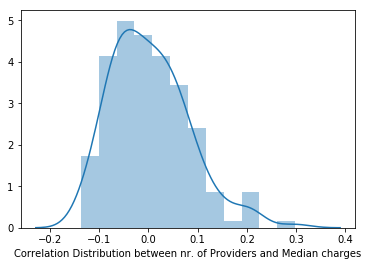

In [18]:
#Plot Distribution of correlation values

x = pd.Series(list(test_dict.values()), name="Correlation Distribution between nr. of Providers and Median charges")

#print(x)
ax = sns.distplot(x)

Based on the above graph, there is no strong correlation between number of providers and average charges. 